# Regresja wielomianowa

![polynomial_regression](regression.png)

Celem regresji wielomianowej jest zamodelowanie relacji między zmienną zależną od zmiennych niezależnych jako funkcję wielomianu n-tego stopnia.

Postać ogólna regresji wielomianowej:

$$ h_{\theta}(x) = \sum_{i=0}^{n} \theta_i x^i $$

Gdzie:

$$ \theta - \text{wektor parametrów modelu} $$ 

## Funkcja kosztu
![MSE](mse.webp)

W celu odpowiedniego dobrania parametrów modelu, trzeba znaleźć minimum funkcji kosztu zdefiniowanej poniższym wzorem:

$$ J = \frac{1}{2m} (X  \theta - y)^T  (X  \theta - y) $$

Gdzie:

$$ m - \text{ilość przykładów} $$ 

Za funkcję kosztu przyjmuje się zmodyfikowaną wersję błędu średniokwadratowego. Dodatkowo dodaje się dzielenie przez 2*m zamiast m, aby gradient z funkcji był lepszej postaci.

## Metoda gradientu prostego
![gradient_descent](gradient.png)

Do znalezienia minimum funckji kosztu można użyć metody gradientu prostego. W tym celu iteracyjnie liczy się gradient funkcji kosztu i aktualizuje się za jego pomocą wektor parametrów modelu aż do uzyskania zbieżności (Różnica między obliczoną funkcją kosztu a funkcją kosztu w poprzedniej iteracji będzie mniejsza od ustalonej wcześniej wartości  $\varepsilon$).

Gradient funkcji kosztu:

$$ \dfrac{\partial J(\theta)}{\partial \theta} = \frac{1}{m}X^T(X \theta - y)$$

Modyfikacja parametrów modelu:

$$ \theta_{new} = \theta - \alpha * \dfrac{\partial J(\theta)}{\partial \theta}$$

Gdzie:

$$ \alpha - \text{współczynnik uczenia} $$

In [46]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas

%matplotlib inline

In [47]:
# Przydatne funkcje
cost_functions = dict()

def cost(theta, X, y):
    """Wersja macierzowa funkcji kosztu"""
    m = len(y)
    J = 1.0 / (2.0 * m) * ((X * theta - y).T * (X * theta - y))
    return J.item()

def gradient(theta, X, y):
    """Wersja macierzowa gradientu funkcji kosztu"""
    return 1.0 / len(y) * (X.T * (X * theta - y)) 

def gradient_descent(fJ, fdJ, theta, X, y, alpha=0.1, eps=10**-7):
    """Algorytm gradientu prostego"""
    current_cost = fJ(theta, X, y)
    logs = [[current_cost, theta]]
    while True:
        theta = theta - alpha * fdJ(theta, X, y)
        current_cost, prev_cost = fJ(theta, X, y), current_cost
        # print(current_cost)
        if abs(prev_cost - current_cost) > 10**15:
            print('Algorytm nie jest zbieżny!')
            break
        if abs(prev_cost - current_cost) <= eps:
            break
        logs.append([current_cost, theta]) 
    return theta, logs

def plot_data(X, y, xlabel, ylabel):
    """Wykres danych"""
    fig = plt.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.scatter([X[:, 1]], [y], c='r', s=50, label='Dane')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.margins(.05, .05)
    plt.ylim(y.min() - 1, y.max() + 1)
    plt.xlim(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1)
    return fig

def plot_data_cost(X, y, xlabel, ylabel):
    """Wykres funkcji kosztu"""
    fig = plt.figure(figsize=(16 * .6, 9 * .6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.scatter([X], [y], c='r', s=50, label='Dane')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.margins(.05, .05)
    plt.ylim(min(y) - 1, max(y) + 1)
    plt.xlim(np.min(X) - 1, np.max(X) + 1)
    return fig

def plot_fun(fig, fun, X):
    """Wykres funkcji `fun`"""
    ax = fig.axes[0]
    x0 = np.min(X[:, 1]) - 1.0
    x1 = np.max(X[:, 1]) + 1.0
    Arg = np.arange(x0, x1, 0.1)
    Val = fun(Arg)
    return ax.plot(Arg, Val, linewidth='2')

In [48]:
def MSE(Y_true, Y_pred):
    """Błąd średniokwadratowy - Mean Squared Error"""
    return np.square(np.subtract(Y_true,Y_pred)).mean()

In [49]:
# Funkcja regresji wielomianowej

def h_poly(Theta, x):
    """Funkcja wielomianowa"""
    return sum(theta * np.power(x, i) for i, theta in enumerate(Theta.tolist()))

def get_poly_data(data, deg):
    """Przygotowanie danych do regresji wielomianowej"""
    m, n_plus_1 = data.shape
    n = n_plus_1 - 1

    X1 = data[:, 0:n]
    X1 /= np.amax(X1, axis=0)

    Xs = [np.ones((m, 1)), X1]

    for i in range(2, deg+1):
        Xn = np.power(X1, i)
        Xn /= np.amax(Xn, axis=0)
        Xs.append(Xn)

    X = np.matrix(np.concatenate(Xs, axis=1)).reshape(m, deg * n + 1)

    y = np.matrix(data[:, -1]).reshape(m, 1)

    return X, y


def polynomial_regression(X, y, n):
    """Funkcja regresji wielomianowej"""
    theta_start = np.matrix([0] * (n+1)).reshape(n+1, 1)
    theta, logs = gradient_descent(cost, gradient, theta_start, X, y)
    return lambda x: h_poly(theta, x), logs

In [50]:
def predict_values(model, data, n):
    """Funkcja predykcji"""
    x, y = get_poly_data(np.array(data), n)
    preprocessed_x = []
    for i in x:
        preprocessed_x.append(i.item(1))
    return y, model(preprocessed_x), MSE(y, model(preprocessed_x))

def plot_and_mse(data, data_test, n):
    """Wykres wraz z MSE"""
    x, y = get_poly_data(np.array(data), n)
    model, logs = polynomial_regression(x, y, n)
    cost_function = [[element[0], i] for i, element in enumerate(logs)]
    cost_functions[n] = cost_function
    
    fig = plot_data(x, y, xlabel='x', ylabel='y')
    plot_fun(fig, model, x)

    y_true, Y_pred, mse = predict_values(model, data_test, n)
    print(f'Wielomian {n} stopnia, MSE = {mse}')

In [51]:
# Wczytanie danych (mieszkania) przy pomocy biblioteki pandas

alldata = pandas.read_csv('data_flats.tsv', header=0, sep='\t',
                          usecols=['price', 'rooms', 'sqrMetres'])
alldata = alldata[['sqrMetres', 'price']]
alldata = alldata.sample(frac=1)
alldata

sqrMetres     price
1102         73  550000.0
1375         78  496573.0
1644         40  310000.0
1434         22  377652.0
1444         30  345180.0
...         ...       ...
384          76  269984.0
214          42  249000.0
24           47  299000.0
1004         57  293848.0
1632        112  329000.0

[1674 rows x 2 columns]

In [52]:
# alldata = np.matrix(alldata[['sqrMetres', 'price']])
data_train = alldata[0:1600]
data_test = alldata[1600:]
data_train = np.matrix(data_train).astype(float)
data_test = np.matrix(data_test).astype(float)

Wielomian 1 stopnia, MSE = 49522013685.367744
Wielomian 2 stopnia, MSE = 148367826800.28735
Wielomian 3 stopnia, MSE = 145689760074.80402


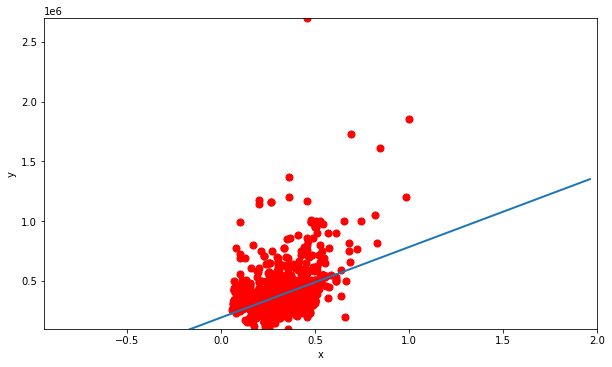

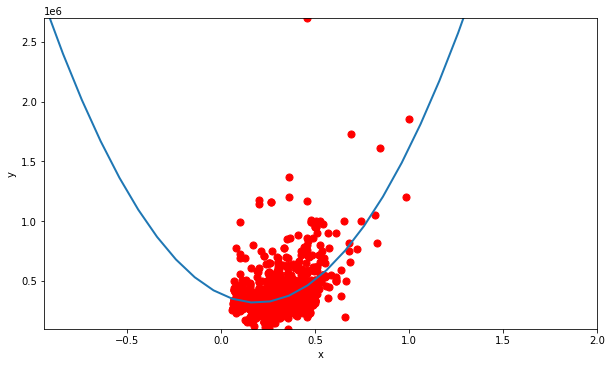

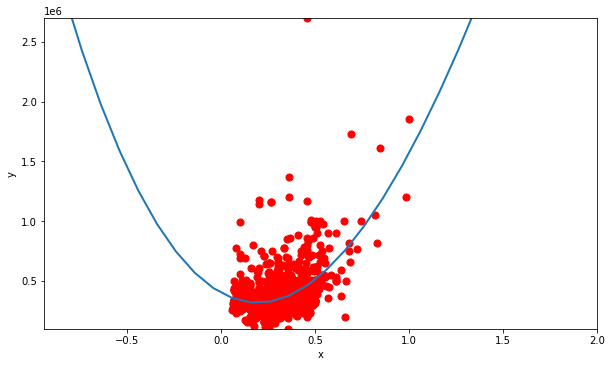

In [53]:
cost_fun_slices = []
for n in range(1, 4):
    plot_and_mse(data_train, data_test, n)
    
    cost_data = cost_functions.get(n)
    cost_x = [line[1] for line in cost_data[:250]]
    cost_y = [line[0] for line in cost_data[:250]]
    cost_fun_slices.append((cost_x, cost_y))

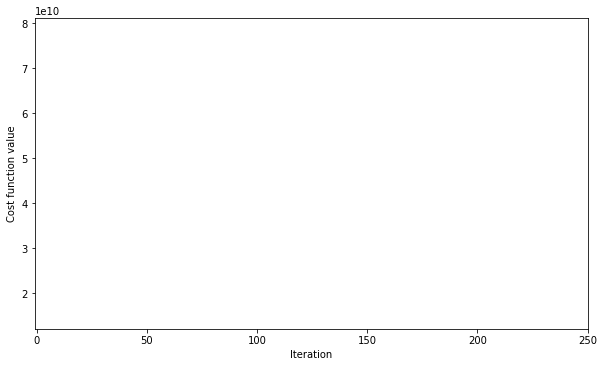

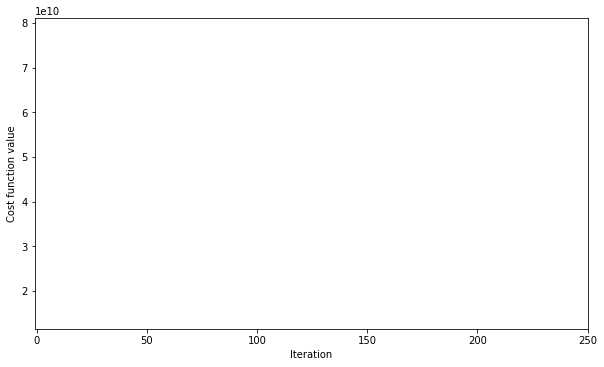

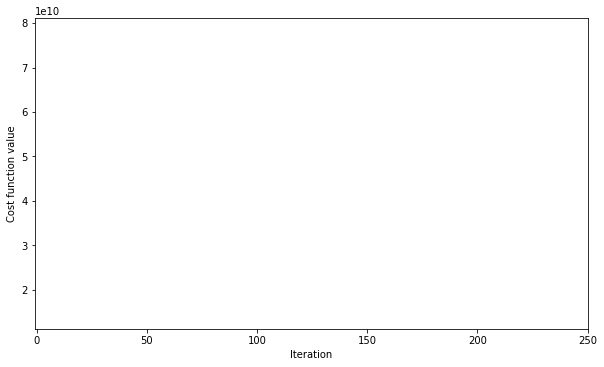

In [54]:
#WYKRESY FUNKCJI KOSZTU
for fig in cost_fun_slices:
    cost_x, cost_y = fig
    fig = plot_data_cost(cost_x, cost_y, "Iteration", "Cost function value")

In [55]:
# Ilość nauki do oceny

In [56]:
data_marks_all = pandas.read_csv('Student_Marks.csv')
data_marks_all

number_courses  time_study   Marks
0                3       4.508  19.202
1                4       0.096   7.734
2                4       3.133  13.811
3                6       7.909  53.018
4                8       7.811  55.299
..             ...         ...     ...
95               6       3.561  19.128
96               3       0.301   5.609
97               4       7.163  41.444
98               7       0.309  12.027
99               3       6.335  32.357

[100 rows x 3 columns]

In [57]:
data_marks_all = data_marks_all[['time_study', 'Marks']]
# data_marks_all = data_marks_all.sample(frac=1)
data_marks_train = data_marks_all[0:70]
data_marks_test = data_marks_all[70:]
data_marks_train = np.matrix(data_marks_train).astype(float)
data_marks_test = np.matrix(data_marks_test).astype(float)

Wielomian 1 stopnia, MSE = 381.1693728350544
Wielomian 2 stopnia, MSE = 394.1863119057109
Wielomian 3 stopnia, MSE = 391.50171107305584


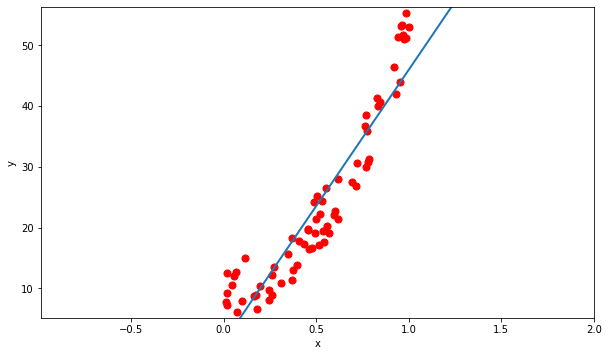

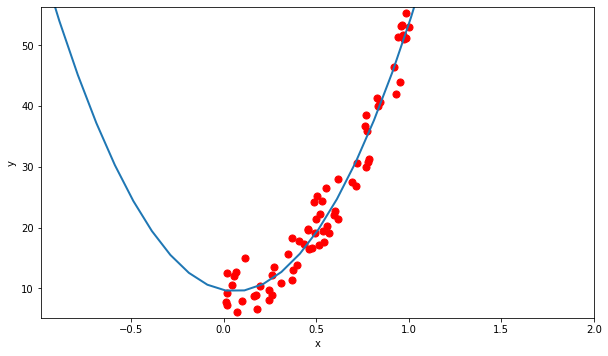

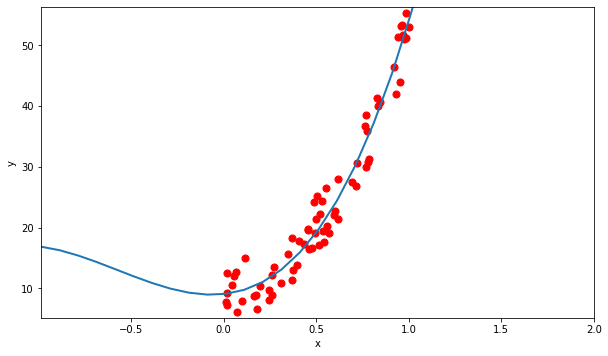

In [58]:
cost_fun_slices = []

for n in range(1, 4):
    plot_and_mse(data_marks_train, data_marks_test, n)
    
    cost_data = cost_functions.get(n)
    cost_x = [line[1] for line in cost_data[:250]]
    cost_y = [line[0] for line in cost_data[:250]]
    cost_fun_slices.append((cost_x, cost_y))

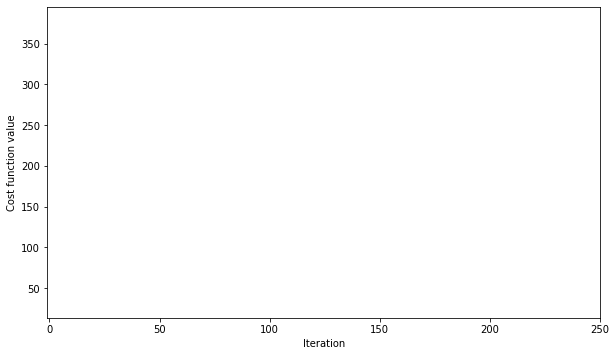

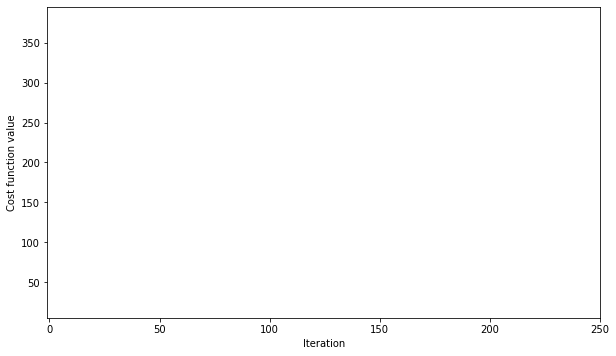

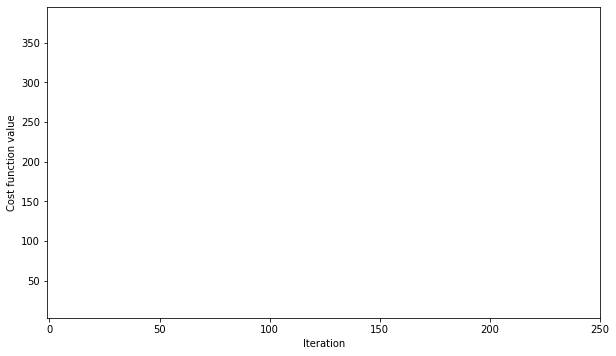

In [59]:
#WYKRESY FUNKCJI KOSZTU
for fig in cost_fun_slices:
    cost_x, cost_y = fig
    fig = plot_data_cost(cost_x, cost_y, "Iteration", "Cost function value")

In [60]:
data_ins = pandas.read_csv('insurance.csv')
data_ins = data_ins.sample(frac=1)
data_ins

age     sex     bmi  children smoker     region      charges
319   32    male  37.335         1     no  northeast   4667.60765
832   28  female  23.845         2     no  northwest   4719.73655
79    41  female  32.965         0     no  northwest   6571.02435
74    44    male  27.400         2     no  southwest   7726.85400
603   64  female  39.050         3     no  southeast  16085.12750
..   ...     ...     ...       ...    ...        ...          ...
328   64  female  33.800         1    yes  southwest  47928.03000
447   56  female  25.650         0     no  northwest  11454.02150
320   34    male  25.270         1     no  northwest   4894.75330
575   58  female  27.170         0     no  northwest  12222.89830
756   39  female  22.800         3     no  northeast   7985.81500

[1338 rows x 7 columns]

In [61]:
data_ins = data_ins[['age', 'charges']]
data_ins_train = data_ins[0:1200]
data_ins_test = data_ins[1200:]
data_ins_train = np.matrix(data_ins_train).astype(float)
data_ins_test = np.matrix(data_ins_test).astype(float)

Wielomian 1 stopnia, MSE = 164742254.38173005
Wielomian 2 stopnia, MSE = 165462756.34970585
Wielomian 3 stopnia, MSE = 165419346.88711548


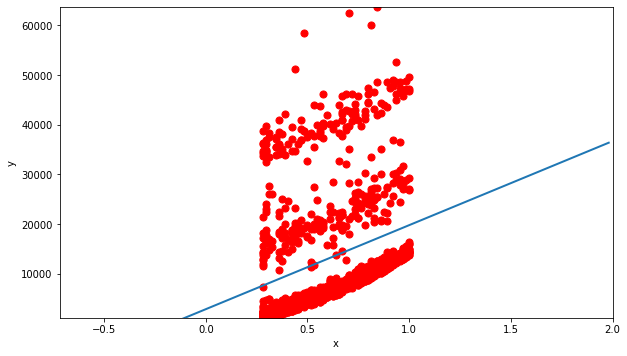

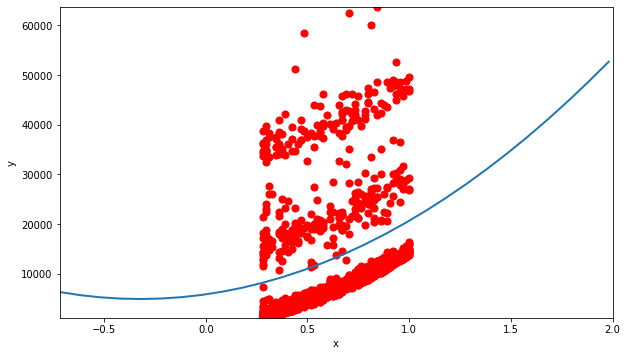

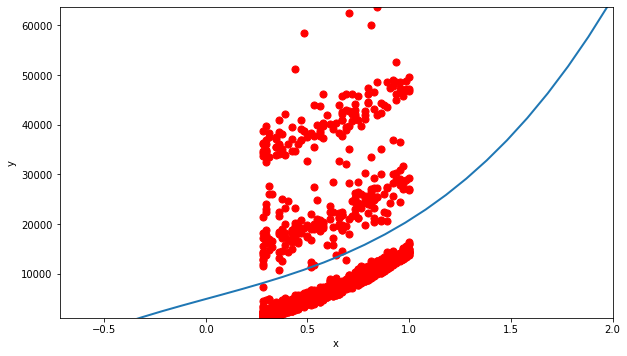

In [62]:
cost_fun_slices = []

for n in range(1, 4):
    plot_and_mse(data_ins_train, data_ins_test, n)
    
    cost_data = cost_functions.get(n)
    cost_x = [line[1] for line in cost_data[:250]]
    cost_y = [line[0] for line in cost_data[:250]]
    cost_fun_slices.append((cost_x, cost_y))

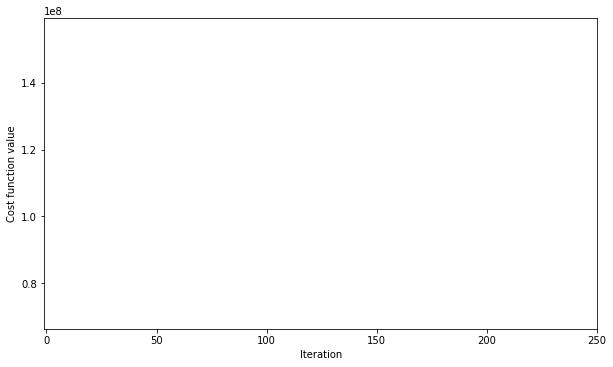

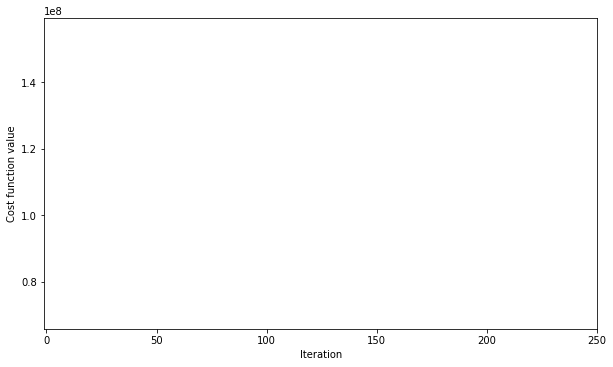

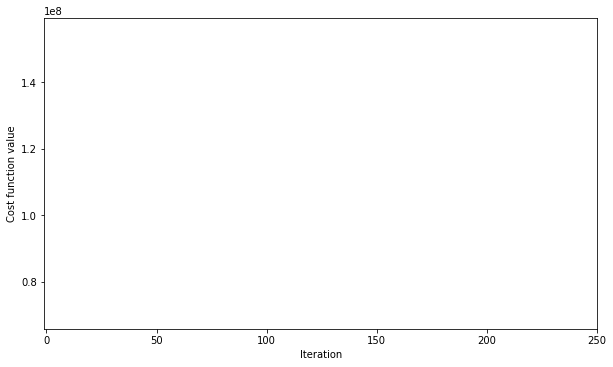

In [63]:
#WYKRESY FUNKCJI KOSZTU
for fig in cost_fun_slices:
    cost_x, cost_y = fig
    fig = plot_data_cost(cost_x, cost_y, "Iteration", "Cost function value")